In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/MyDrive/DataTrain.txt"
test_path = "/content/drive/MyDrive/DataTest (1).txt"

In [ ]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 41.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

**Encoder : 2->Pos    1->Neu   0->Neg**

In [ ]:
from gensim.utils import simple_preprocess
def labelencoder(text):
        if text=='positive':
            return 2
        elif text == 'negative':
            return 0
        else:
          return 1

**Read Data Train**

In [ ]:
# Hàm đọc file
def get_train_data(file_path):
  train_text = []
  train_label = []
  with open(file_path, "r", encoding="utf-8") as f:
    lines = f.read().splitlines()
    for line in lines:
      try:
        data = line.split("\t")
        train_text.append(' '.join(simple_preprocess(data[1])))
        train_label.append(labelencoder(data[0]))
      except:
        continue

  return [train_text, train_label]


**Read Data Test**

In [ ]:
# Hàm đọc file
def get_test_data(file_path):
  test_text = []
  test_label = []
  with open(file_path, "r", encoding="utf-8") as f:
    lines = f.read().splitlines()
    for line in lines:
      try:
        data = line.split("\t")
        test_text.append(' '.join(simple_preprocess(data[1])))
        test_label.append(labelencoder(data[0]))
      except:
        continue

  return [test_text, test_label]

**Save Data Train and Test**

In [ ]:
import numpy as np
train_data = get_train_data(train_path)
X_train, y_train = train_data[0], train_data[1]

test_data = get_test_data(test_path)
X_test, y_test = test_data[0], test_data[1]

len(y_test)

100

**Import BERT model**

In [ ]:
Bert_Preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
Bert_Encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/2")

**Get embeding vectors for few sample statements**

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = Bert_Preprocess(sentences)
    return Bert_Encoder(preprocessed_text)['pooled_output']

a = get_sentence_embeding([
    "He's a good teacher",
    "Đó là một người giáo viên tốt"]
)
a[0].shape

TensorShape([256])

**Build Model**

In [ ]:
from keras.models import Sequential
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = Bert_Preprocess(text_input)
outputs = Bert_Encoder(preprocessed_text)
net = outputs['pooled_output']
# Neural network layers
l = Sequential()
l = tf.keras.layers.Dense(512, activation='relu')(net)
l = tf.keras.layers.Dropout(0.1)(net)
l = tf.keras.layers.Dense(256, activation='relu')(net)
l = tf.keras.layers.Dropout(0.1)(net)
l = tf.keras.layers.Dense(128, activation='relu')(net)
l = tf.keras.layers.Dropout(0.1)(net)
l = tf.keras.layers.Dense(64, activation='relu')(net)
l = tf.keras.layers.Dropout(0.1)(net)
l = tf.keras.layers.Dense(32, activation='relu')(net)
l = tf.keras.layers.Dropout(0.1)(net)
l = tf.keras.layers.Dense(16, activation='relu')(net)
l = tf.keras.layers.Dropout(0.1)(net)
l = tf.keras.layers.Dense(8, activation='relu')(net)
l = tf.keras.layers.Dropout(0.1)(net)
l = tf.keras.layers.Dense(4, activation='relu')(net)
l = tf.keras.layers.Dropout(0.1)(net)
l = tf.keras.layers.Dropout(0.1, name="dropout")(net)
l = tf.keras.layers.Dense(3, activation='softmax', name="output")(net)

# Use inputs and outputs to construct a final model

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

**Train The Model**

In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np
y_new_train = to_categorical(y_train, num_classes=3)

In [ ]:
y_train
type(y_train)

list

In [ ]:
#y_new_train = y_new_train.astype(int)
y_new_train = np.array(y_new_train)
type(y_new_train)

numpy.ndarray

In [ ]:
y_new_train

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
X_train = [[sentence] for sentence in X_train]


In [ ]:
X_train = np.array(X_train)

In [ ]:
X_train

array([['tài liệu được bổ sung nhiều và đầy đủ trên moodle'],
       ['giảng viên phải nên cho ví dụ cụ thể những phần quan trọng nên nói kỹ có thể lấy ví dụ minh họa tránh việc lập đi lập lại nhiều lần sẽ tạo cảm giác chán cho sinh viên'],
       ['bài tập đa dạng cụ thể'],
       ...,
       ['chiếm điểm bất công so với lớp của giáo viên dạy cùng môn'],
       ['cô giáo nhiệt tình giảng bài dễ hiểu'],
       ['những thứ này không nên giảng dạy vì không phải cứ học những thứ đó là thành công rất phí thời gian đến lớp']],
      dtype='<U446')

In [ ]:
import pandas as pd
data_frame_X = pd.DataFrame(X_train)
data_frame_y = pd.DataFrame(y_new_train)

**Data Frame Info**

In [ ]:
data_frame_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       4999 non-null   object
dtypes: object(1)
memory usage: 39.2+ KB


In [ ]:
data_frame_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4999 non-null   float32
 1   1       4999 non-null   float32
 2   2       4999 non-null   float32
dtypes: float32(3)
memory usage: 58.7 KB


**Train Model**

In [ ]:
model.fit(X_train, y_new_train, epochs = 50, validation_split=0.2)

Epoch 1/50
125/125 [==============================] - 18s 144ms/step - loss: 0.8073 - categorical_accuracy: 0.6432 - val_loss: 1.0223 - val_categorical_accuracy: 0.5170
Epoch 2/50
125/125 [==============================] - 20s 162ms/step - loss: 0.8037 - categorical_accuracy: 0.6444 - val_loss: 1.0258 - val_categorical_accuracy: 0.5040
Epoch 3/50
125/125 [==============================] - 19s 149ms/step - loss: 0.8013 - categorical_accuracy: 0.6437 - val_loss: 1.0236 - val_categorical_accuracy: 0.5080
Epoch 4/50
125/125 [==============================] - 18s 144ms/step - loss: 0.7984 - categorical_accuracy: 0.6474 - val_loss: 1.0158 - val_categorical_accuracy: 0.5070
Epoch 5/50
125/125 [==============================] - 19s 150ms/step - loss: 0.7961 - categorical_accuracy: 0.6459 - val_loss: 1.0103 - val_categorical_accuracy: 0.5120
Epoch 6/50
125/125 [==============================] - 19s 152ms/step - loss: 0.7931 - categorical_accuracy: 0.6509 - val_loss: 1.0081 - val_categorical_acc

In [ ]:
Test_array = model.predict(X_test)

4/4 [==============================] - 0s 93ms/step


In [ ]:
Test_array[0]

array([0.19692282, 0.5355768 , 0.2675003 ], dtype=float32)

In [ ]:
y_test

In [ ]:
import numpy as np
y_predict = []
for i in range(0,100):
  max_index = np.argmax(Test_array[i])
  y_predict.append(max_index)
y_predict

In [ ]:
count = 0
for i in range(100):
  if y_test[i] == y_predict[i]:
    count += 1
print('Xac suat du doan dung: ', (count/100))
print('So luong du doan dung: ', count)

Xac suat du doan dung:  0.71
So luong du doan dung:  71


**Double Column Chart**

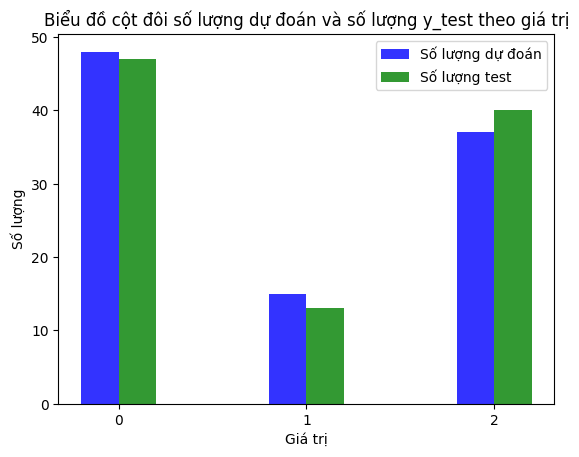

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Đếm số lượng dự đoán cho mỗi giá trị 0, 1, 2
counts_predict = np.bincount(y_predict)
counts_test = np.bincount(y_test)

# Tạo mảng chỉ số để xác định vị trí cột
index = np.arange(3)

# Kích thước cột
bar_width = 0.2

plt.bar(index, counts_predict, bar_width, alpha=0.8, color='b', label='Số lượng dự đoán')
plt.bar(index + bar_width, counts_test, bar_width, alpha=0.8, color='g', label='Số lượng test')

# Đặt nhãn cho trục x và trục y
plt.xlabel('Giá trị')
plt.ylabel('Số lượng')
plt.title('Biểu đồ cột đôi số lượng dự đoán và số lượng y_test theo giá trị')
plt.xticks(index + bar_width/2, ['0', '1', '2'])

# Hiển thị chú thích
plt.legend()
plt.show()


**Confusion Matrix**

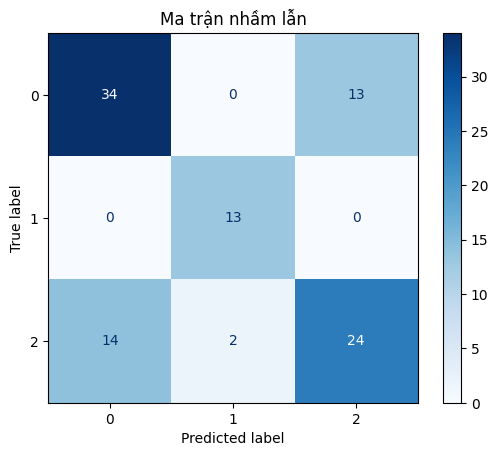

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_predict)

# Vẽ biểu đồ ma trận nhầm lẫn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1', '2'])
disp.plot(cmap='Blues')

plt.title('Ma trận nhầm lẫn')
plt.show()


**F1 MACRO**

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Tính F1 Macro
f1_macro = f1_score(y_test, y_predict, average='macro')

print("F1 Macro:", f1_macro)

F1 Macro: 0.7559125085440875
